<a href="https://colab.research.google.com/github/ucheokechukwu/Stock-Prediction-with-Media-Sentiment-Analysis-/blob/main/src/Feature_Engineering_LDA_Experiment_Class_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA Topic modelling

Using LDA to get topic labels for the reddit data

Experiment 1: kept 'netflix'.

In [ ]:
!pip install nlp
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's depe

In [ ]:
import re
import nltk
import spacy
import gensim


In [ ]:
import pyLDAvis
import nlp
nltk.download('stopwords')
import pandas as pd
import numpy as np

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# spacy for lematization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/output/netflix_14_01_22_1686705755.csv').fillna("")
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1414, 5)

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,post_date,kind,title,selftext,upvotes
0,2021-04-24 15:24:04,Submission,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,410
1,2023-02-02 09:35:27,Submission,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,581
2,2023-06-13 13:59:29,Submission,Netflix Revealed the First Trailer for 'They C...,,212
3,2023-06-14 00:12:11,Submission,(Canada) - Why is DUNE not in 4K/UHD ?,I would think that this one would be a no brai...,3
4,2023-06-14 00:12:32,Submission,The Days,I was hyped for this series. It reminded me of...,2


In [ ]:
df['content'] = df['title'] + df['selftext']
df = df.drop(columns=['title', 'selftext', 'kind'])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,post_date,upvotes,content
0,2021-04-24 15:24:04,410,/r/Netflix Discord ServerWe are pleased to ann...
1,2023-02-02 09:35:27,581,Netflix Announces Plans to Crack Down on Passw...
2,2023-06-13 13:59:29,212,Netflix Revealed the First Trailer for 'They C...
3,2023-06-14 00:12:11,3,(Canada) - Why is DUNE not in 4K/UHD ?I would ...
4,2023-06-14 00:12:32,2,The DaysI was hyped for this series. It remind...


In [ ]:
# preprocessing data
# convert to list
data = df['content'].values.tolist()
data = [re.sub('\S*@\S*\s?', '', i) for i in data] #emails
data = [re.sub('\s+', ' ', i) for i in data] #remove new line chars
data = [re.sub("\'", "", i) for i in data]

data = [sentence.replace('netflix', '') for sentence in data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence '\S'
<>:5: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\S'
<>:5: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-9-a3fb61cb24af>:4: DeprecationWarning: invalid escape sequence '\S'
  data = [re.sub('\S*@\S*\s?', '', i) for i in data] #emails
<ipython-input-9-a3fb61cb24af>:5: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', i) for i in data] #remove new line chars


In [ ]:
# tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                             deacc=True)) # removes punctuations
data_words = list(sent_to_words(data))

data_words[:1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['netflix',
  'discord',
  'serverwe',
  'are',
  'pleased',
  'to',
  'announce',
  'we',
  'have',
  'affiliated',
  'with',
  'https',
  'discord',
  'gg',
  'netflix',
  'which',
  'will',
  'be',
  'the',
  'subreddit',
  'discord',
  'server',
  'for',
  'the',
  'netflix',
  'subreddit',
  'feel',
  'free',
  'to',
  'join',
  'the',
  'server',
  'and',
  'talk',
  'about',
  'everything',
  'netflix',
  'related',
  'including',
  'shows',
  'on',
  'netflix',
  'as',
  'well']]

In [ ]:
# remove stop words and lemmatize tokens

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) \
             if word not in stop_words] for doc in texts]

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(texts):
    texts_out = []
    for text in texts:
        doc = nlp(" ".join(text))
        texts_out.append([token.lemma_ for token in doc \
                          if token.pos_ == 'NOUN'])
    return texts_out


# remove stop words
data = remove_stopwords(data_words)
data = lemmatization(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data[:2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['announce',
  'discord',
  'server',
  'subreddit',
  'join',
  'server',
  'talk',
  'netflix'],
 ['plan',
  'password',
  'sharing',
  'post',
  'thread',
  'subject',
  'removal',
  'plan',
  'crackdown',
  'password',
  'sharing',
  'thread',
  'uptick',
  'post',
  'decision',
  'clamp',
  'password',
  'account',
  'sharing',
  'discuss',
  'post',
  'flooding',
  'subbredit',
  'thread',
  'discussion',
  'policy',
  'mod',
  'employee',
  'contact',
  'customer',
  'service',
  'link',
  'speak',
  'mind',
  'follow',
  'rule',
  'comment',
  'thank',
  'team']]

In [ ]:
# create dictionary

id2word = corpora.Dictionary(data)
# create corpus
corpus = [id2word.doc2bow(text) for text in data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    compute c_v coherence for various number of topics
    parameters:
    dictionary: gensim dictionary
    corpus: gensim corpus
    texts: list of input texts
    limit: max num of topics

    returns:
    model_list: list of LDA topic models
    coherence_values: coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               num_topics=num_topics,
                                               random_state=100,
                                               chunksize=200,
                                               passes=10,
                                               per_word_topics=True,
                                               id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                       texts=texts,
                                       dictionary=dictionary,
                                       coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                       corpus=corpus,
                                                       texts=data,
                                                       start=2,
                                                       limit=12,
                                                       step=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


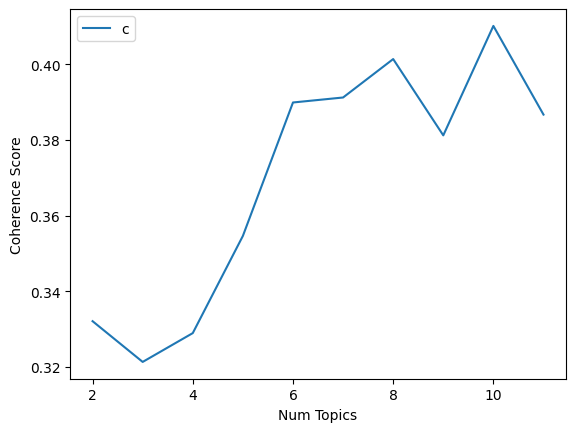

In [ ]:
# show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc='best')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


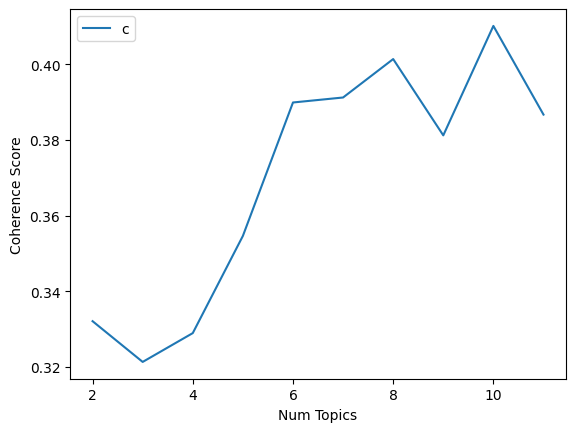

In [ ]:
# show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [ ]:
## alpha and beta hyperparameter tuning

# supporting function

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=5,
                                               random_state=100,
                                               chunksize=200,
                                               passes=10,
                                               alpha=a,
                                               eta=b,
                                               per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                        texts=data,
                                        dictionary=id2word,
                                        coherence='c_v')

    return coherence_model_lda.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_set'] ={}

# topics range
min_topics = 2
max_topics = 12

step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
              corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
if 1==1:
    pbar = tqdm.tqdm(total=540)

    for i in range(len(corpus_sets)):
        # itearte through the number of topics
        for k in topics_range:
            # iterate through the alpha values
            for a in alpha:
                # iterate through the beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i],
                                                 dictionary=id2word,
                                                 k=k,
                                                 a=a,
                                                 b=b)
                    # save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
    pbar.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
600it [35:18,  3.53s/it]


In [ ]:
results_df = pd.DataFrame(model_results)
max_coherence_index = results_df['Coherence'].idxmax()
display(results_df.loc[max_coherence_index])
filter=results_df['Validation_Set'] == '100% Corpus'
results_df[filter].sort_values('Coherence', ascending=False)[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation_Set    75% Corpus
Topics                     2
Alpha                   0.61
Beta                    0.31
Coherence           0.570713
Name: 11, dtype: object

,Validation_Set,Topics,Alpha,Beta,Coherence
463,100% Corpus,7,0.61,0.91,0.495538
553,100% Corpus,10,0.61,0.91,0.495538
523,100% Corpus,9,0.61,0.91,0.495538
433,100% Corpus,6,0.61,0.91,0.495538
343,100% Corpus,3,0.61,0.91,0.495538
583,100% Corpus,11,0.61,0.91,0.495538
373,100% Corpus,4,0.61,0.91,0.495538
403,100% Corpus,5,0.61,0.91,0.495538
313,100% Corpus,2,0.61,0.91,0.495538
493,100% Corpus,8,0.61,0.91,0.495538


In [ ]:
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10,
                                               random_state=100,
                                               chunksize=200,
                                               passes=50,
                                               alpha=0.61,
                                                  eta=0.31,
                                               per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model_final,
                                        texts=data,
                                        dictionary=id2word,
                                        coherence='c_v')
coherence_model_lda.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.44775589144625644

In [ ]:
# visualie the topics/keywords using pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

In [ ]:
## Topic distribution across documents

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ','.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                 round(prop_topic,4),
                                                                 topic_keywords]),
                                                      ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # add original text to the end of the subject
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_dominant_topic = format_topics_sentences(lda_model_final, corpus, data)
df_dominant_topic.to_csv('/content/drive/MyDrive/output/lda10.csv')
df_dominant_topic


In [ ]:
## Topic distribution across documents

def get_secodary_topics(ldamodel=None, corpus=corpus, texts=data):
    # init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ','.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                 round(prop_topic,4),
                                                                 topic_keywords]),
                                                      ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Secondary_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # add original text to the end of the subject
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_dominant_topic_2 = get_secodary_topics(lda_model_final, corpus, data)
df_dominant_topic_2.to_csv('/content/drive/MyDrive/output/lda10___2.csv')
df_dominant_topic_2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: ignored

In [ ]:
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name='Num Documents')
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values('Dominant_Topic')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Num Documents
5,0,133
2,1,164
1,2,185
0,3,268
6,4,117
3,5,144
7,6,115
8,7,87
4,8,144
9,9,57


In [ ]:
# word cloud od top N words proportional to their weights

import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords = stop_words,
                 background_color = 'white',
                 width=2500,
                 height=2800,
                 max_words=15,
                 colormap='tab10',
                 color_func=lambda *args, **kwargs:cols[i],
                 prefer_horizontal=1.0)

topics = lda_model_final.show_topics(formatted=False)
display(topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('list', 0.067510694),
   ('top', 0.025282137),
   ('release', 0.025174778),
   ('menu', 0.021384554),
   ('power', 0.020719042),
   ('history', 0.017400594),
   ('special', 0.015217871),
   ('find', 0.014361426),
   ('star', 0.013821991),
   ('trilogy', 0.013259655)]),
 (1,
  [('home', 0.04633857),
   ('account', 0.033266157),
   ('fee', 0.026036855),
   ('ad', 0.023671864),
   ('plan', 0.022884782),
   ('year', 0.0210056),
   ('password', 0.019097473),
   ('service', 0.018717494),
   ('netflix', 0.016439984),
   ('update', 0.015894085)]),
 (2,
  [('watch', 0.038112678),
   ('time', 0.027439242),
   ('content', 0.024679853),
   ('user', 0.021363953),
   ('day', 0.02012582),
   ('category', 0.017512774),
   ('title', 0.01710897),
   ('com', 0.015222581),
   ('hour', 0.013970184),
   ('thing', 0.012022842)]),
 (3,
  [('season', 0.16044018),
   ('episode', 0.12846476),
   ('series', 0.05687793),
   ('netflix', 0.055331618),
   ('trailer', 0.025080072),
   ('credit', 0.008097686),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


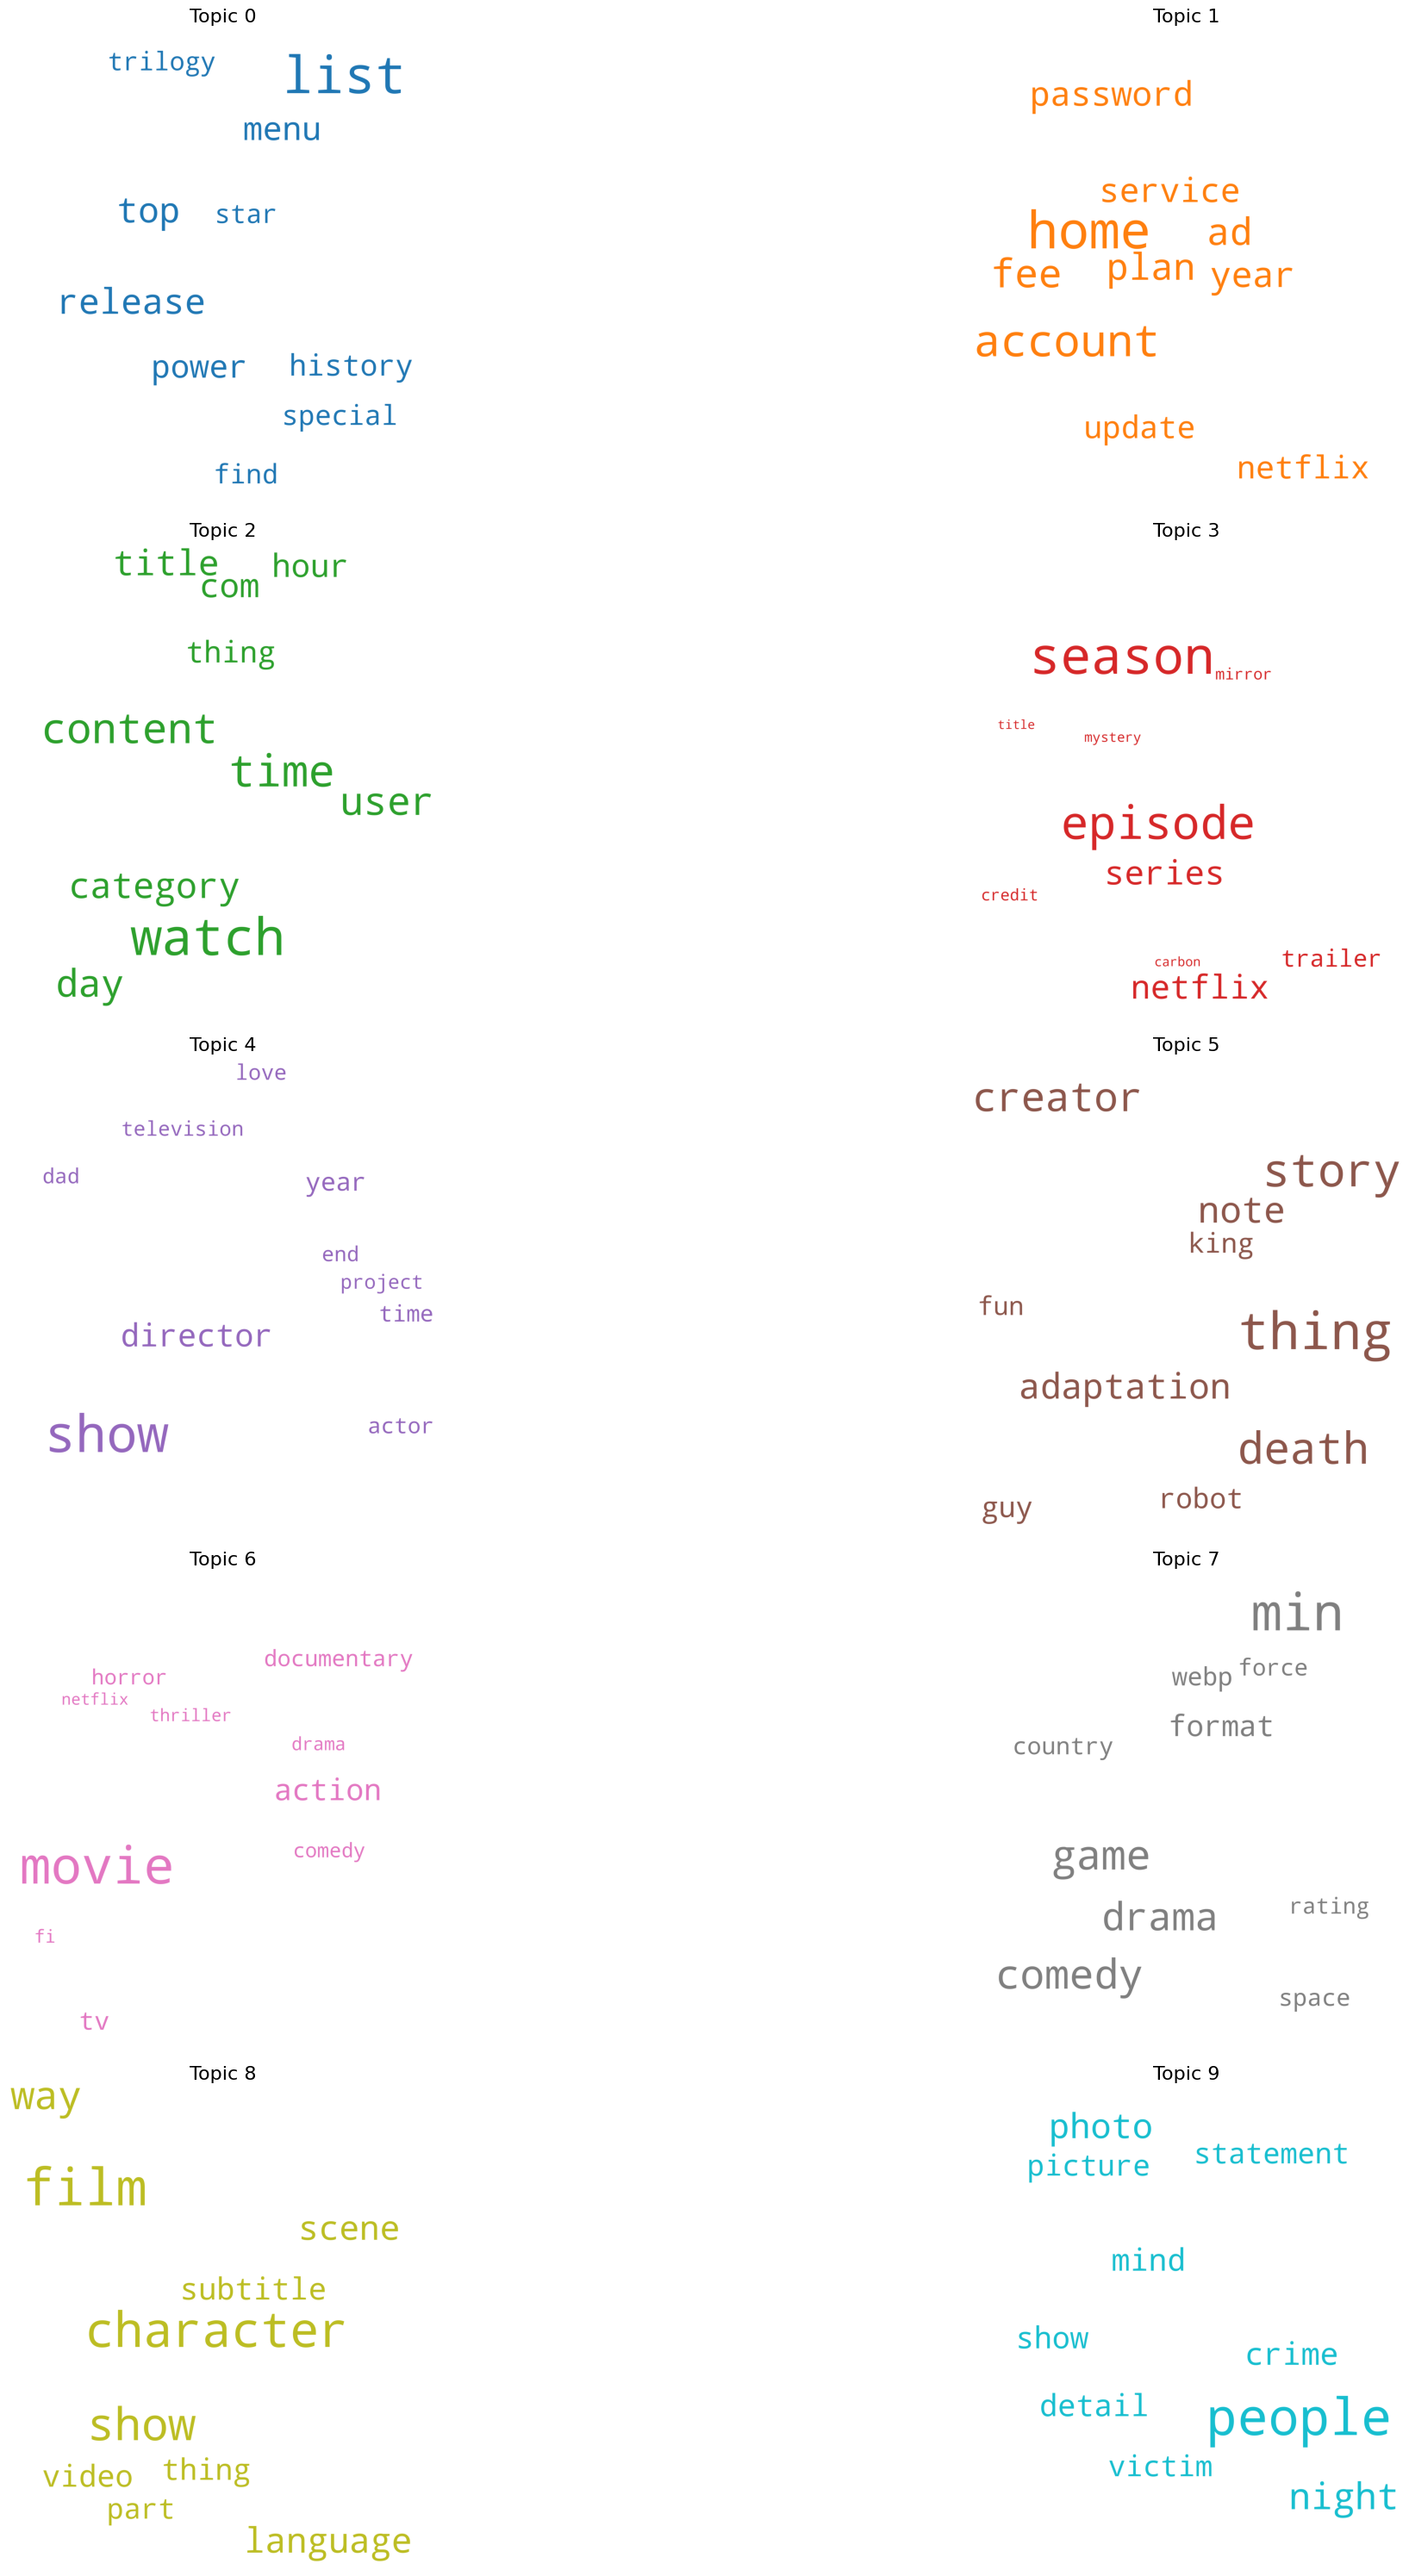

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(30,30),
                        sharex=True,
                        sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    if i==10:
        break

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# saving the lda model

In [ ]:


from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("/content/drive/MyDrive/output/lda_10")
lda_model_final.save(temp_file)

# Load a potentially pretrained model from disk.
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# testing the lda model

coherence_model_lda = CoherenceModel(model=lda,
                                        texts=data,
                                        dictionary=id2word,
                                        coherence='c_v')
coherence_model_lda.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.44775589144625644

In [ ]:
pd.DataFrame(model_results).to_csv('/content/drive/MyDrive/output/lda_tuning_results_new_10.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Topic distribution across documents

def get_topics(ldamodel=None, corpus=corpus[:-2], texts=data):
    # init output
    sent_topics = []

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        sent_topics.append(row)
    return(sent_topics)


df_dominant_topic_2 = get_topics(lda_model_final, corpus, data)
pd.DataFrame(df_dominant_topic_2).to_csv('/content/drive/MyDrive/output/topic_list_10', index=False)
df_dominant_topic_2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pd.read_csv('/content/drive/MyDrive/output/topic_list_10').head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,"(5, 0.46435988)","(7, 0.111408025)","(3, 0.10872726)","(1, 0.04892742)","(6, 0.046377774)","(2, 0.044301324)","(0, 0.044292565)","(8, 0.04401573)","(4, 0.04383772)","(9, 0.04375228)"
1,"(1, 0.5956957)","(2, 0.20104623)","(7, 0.08110332)","(9, 0.03473078)","(4, 0.017070355)","(5, 0.014535195)","(8, 0.014281939)","(0, 0.013938561)","(6, 0.013804678)","(3, 0.013793265)"
2,"(3, 0.2685075)","(4, 0.18438266)","(0, 0.069016)","(5, 0.06889745)","(7, 0.068835504)","(6, 0.06841658)","(9, 0.06809956)","(1, 0.06803118)","(2, 0.06795267)","(8, 0.06786085)"
3,"(5, 0.49227804)","(8, 0.057446714)","(2, 0.057315946)","(7, 0.056619395)","(0, 0.056551386)","(6, 0.056110505)","(3, 0.056041636)","(4, 0.055978563)","(9, 0.055857584)","(1, 0.055800218)"
4,"(3, 0.35202834)","(5, 0.14355567)","(4, 0.07341533)","(9, 0.062253878)","(0, 0.061900355)","(7, 0.06187762)","(6, 0.061572675)","(1, 0.061195977)","(2, 0.061112903)","(8, 0.06108727)"
